# NGSIM Traffic Data - Exploratory Data Analysis

Analyzing vehicle trajectory data from Peachtree Street.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.float_format', '{:.2f}'.format)

## 1. Load & Clean Data

In [4]:
csv_file = './data/NGSIM_Data_20260126.csv'

df = pd.read_csv(csv_file, low_memory=False)

print(f"Loaded {len(df):,} records from {len(csv_file)} file(s)")
df.head()

Loaded 500,000 records from 30 file(s)


,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,...,D_Zone,Int_ID,Section_ID,Direction,Movement,Preceding,Following,Space_Headway,Time_Headway,Location
0,352,3380,"1,156",1163368300,-5.36,0,2230502.92,1375532.94,15.00,6.50,...,201,0,1,4,1,0,455,0,0,peachtree
1,352,3379,"1,156",1163368200,-4.62,4.566,2230503.11,1375537.93,15.00,6.50,...,201,0,1,4,1,0,455,0,0,peachtree
2,352,3378,"1,156",1163368100,-4.71,7.606,2230502.73,1375540.95,15.00,6.50,...,201,0,1,4,1,0,455,0,0,peachtree
3,352,3377,"1,156",1163368000,-4.18,11.177,2230502.91,1375544.69,15.00,6.50,...,201,0,1,4,1,0,455,0,0,peachtree
4,39,208,"1,598",1163051100,11.57,12.311,2230518.57,1375546.76,15.00,7.00,...,214,0,1,2,1,17,0,28.27,113.1,peachtree


In [5]:
df['Lane_ID'].value_counts().sort_index()

Lane_ID
0        106288
1        209214
11        35658
2        146108
3          1641
4            56
9,999      1035
Name: count, dtype: int64

In [6]:
# Clean data - remove commas from numbers and convert to numeric
numeric_cols = ['Vehicle_ID', 'Frame_ID', 'Total_Frames', 'Global_Time',
                'Local_X', 'Local_Y', 'Global_X', 'Global_Y',
                'v_length', 'v_Width', 'v_Class', 'v_Vel', 'v_Acc',
                'Lane_ID', 'Preceding', 'Following', 'Space_Headway', 'Time_Headway']

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')

# Add vehicle type labels
df['Vehicle_Type'] = df['v_Class'].map({1: 'Motorcycle', 2: 'Car', 3: 'Truck'})

# Clean time headway (9999.99 = no vehicle ahead)
df['Time_Headway'] = df['Time_Headway'].replace(9999.99, np.nan)

df = df.drop(columns=['Location'])

# Remove impossible speeds (negative or extremely high)
df = df[(df['v_Vel'] >= 0) & (df['v_Vel'] <= 120)]

# Convert Global_Time to seconds (relative time)
df['time_sec'] = (df['Global_Time'] - df['Global_Time'].min()) / 1000


print("Data cleaned!")
df.head()

Data cleaned!


,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,...,Int_ID,Section_ID,Direction,Movement,Preceding,Following,Space_Headway,Time_Headway,Vehicle_Type,time_sec
0,352,3380,1156,1163368300,-5.36,0.00,2230502.92,1375532.94,15.00,6.50,...,0,1,4,1,0,455,0.00,0.00,Car,345.30
1,352,3379,1156,1163368200,-4.62,4.57,2230503.11,1375537.93,15.00,6.50,...,0,1,4,1,0,455,0.00,0.00,Car,345.20
2,352,3378,1156,1163368100,-4.71,7.61,2230502.73,1375540.95,15.00,6.50,...,0,1,4,1,0,455,0.00,0.00,Car,345.10
3,352,3377,1156,1163368000,-4.18,11.18,2230502.91,1375544.69,15.00,6.50,...,0,1,4,1,0,455,0.00,0.00,Car,345.00
4,39,208,1598,1163051100,11.57,12.31,2230518.57,1375546.76,15.00,7.00,...,0,1,2,1,17,0,28.27,113.10,Car,28.10


## 2. Quick Overview

In [7]:
print(f"Total records: {len(df):,}")
print(f"Unique vehicles: {df['Vehicle_ID'].nunique():,}")
print(f"Lanes: {sorted(df['Lane_ID'].dropna().unique().astype(int))}")
print(f"\nVehicle types:")
print(df.groupby('Vehicle_ID')['Vehicle_Type'].first().value_counts())
print(df.columns)

Total records: 500,000
Unique vehicles: 1,137
Lanes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(11), np.int64(9999)]

Vehicle types:
Vehicle_Type
Car           1110
Truck           26
Motorcycle       1
Name: count, dtype: int64
Index(['Vehicle_ID', 'Frame_ID', 'Total_Frames', 'Global_Time', 'Local_X',
       'Local_Y', 'Global_X', 'Global_Y', 'v_length', 'v_Width', 'v_Class',
       'v_Vel', 'v_Acc', 'Lane_ID', 'O_Zone', 'D_Zone', 'Int_ID', 'Section_ID',
       'Direction', 'Movement', 'Preceding', 'Following', 'Space_Headway',
       'Time_Headway', 'Vehicle_Type', 'time_sec'],
      dtype='str')


In [8]:
# Summary stats for key variables
df[['v_Vel', 'v_Acc', 'Space_Headway', 'Time_Headway']].describe()

,v_Vel,v_Acc,Space_Headway,Time_Headway
count,500000.00,500000.00,500000.00,445715.00
mean,13.48,-0.02,70.72,67.33
std,15.24,4.47,168.21,603.90
min,0.00,-12.27,0.00,0.00
25%,0.05,0.00,0.00,0.00
50%,5.37,0.00,23.42,1.61
75%,26.56,0.00,48.95,9.04
max,55.82,12.27,1855.75,31864.08


## 3. Visualizations

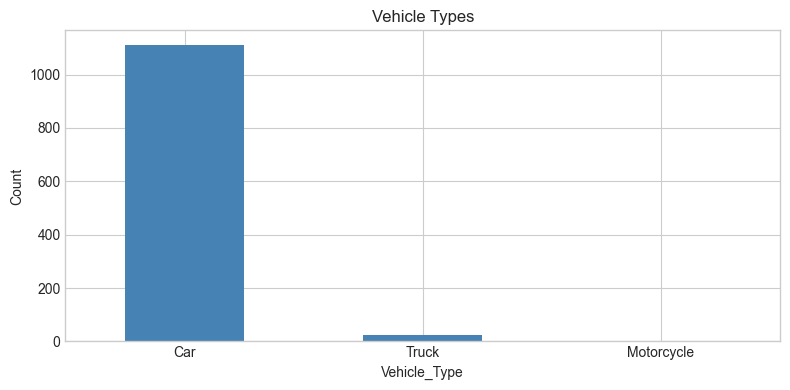

In [9]:
# Vehicle type distribution
fig, ax = plt.subplots(figsize=(8, 4))
df.groupby('Vehicle_ID')['Vehicle_Type'].first().value_counts().plot(kind='bar', color='steelblue', ax=ax)
ax.set_title('Vehicle Types')
ax.set_ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

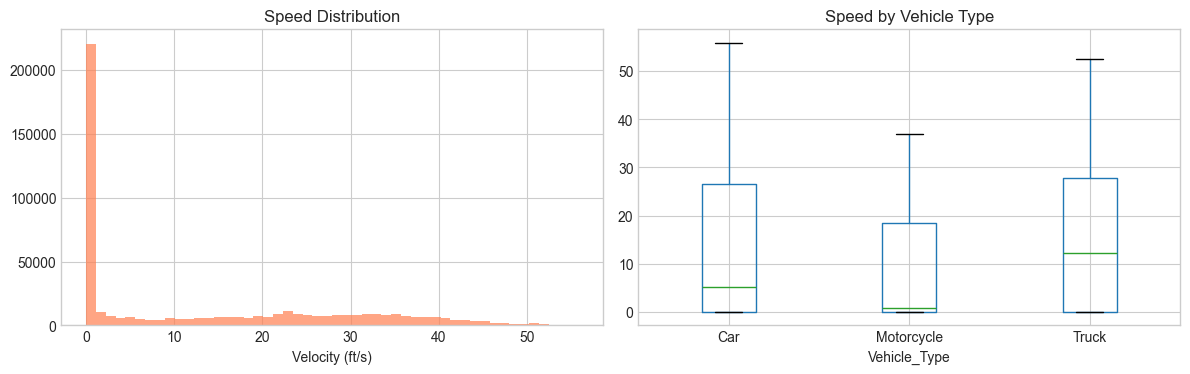

In [10]:
# Speed distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

df['v_Vel'].hist(bins=50, ax=axes[0], color='coral', alpha=0.7)
axes[0].set_xlabel('Velocity (ft/s)')
axes[0].set_title('Speed Distribution')

df.boxplot(column='v_Vel', by='Vehicle_Type', ax=axes[1])
axes[1].set_title('Speed by Vehicle Type')
plt.suptitle('')
plt.tight_layout()
plt.show()

"The histogram shows that most vehicles in the dataset are moving slowly, with fewer vehicles at higher speeds. This reflects typical traffic conditions where many vehicles may be in stop-and-go traffic while a few move faster."

"The boxplot shows how speeds vary by vehicle type. Cars and trucks have wider speed ranges, while motorcycles are mostly slower. Median speeds are generally low, indicating most vehicles are in congested or slow-moving traffic."

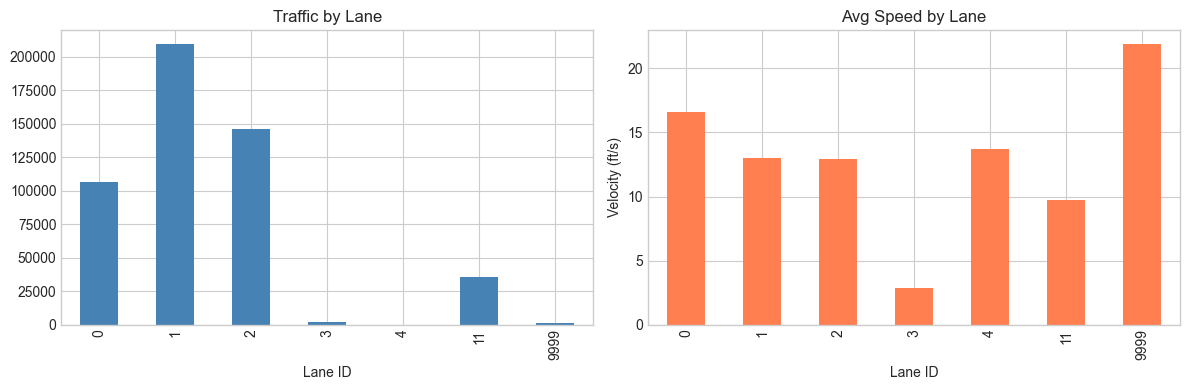

In [11]:
# Lane usage
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

df['Lane_ID'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Traffic by Lane')
axes[0].set_xlabel('Lane ID')

df.groupby('Lane_ID')['v_Vel'].mean().sort_index().plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Avg Speed by Lane')
axes[1].set_xlabel('Lane ID')
axes[1].set_ylabel('Velocity (ft/s)')

plt.tight_layout()
plt.show()

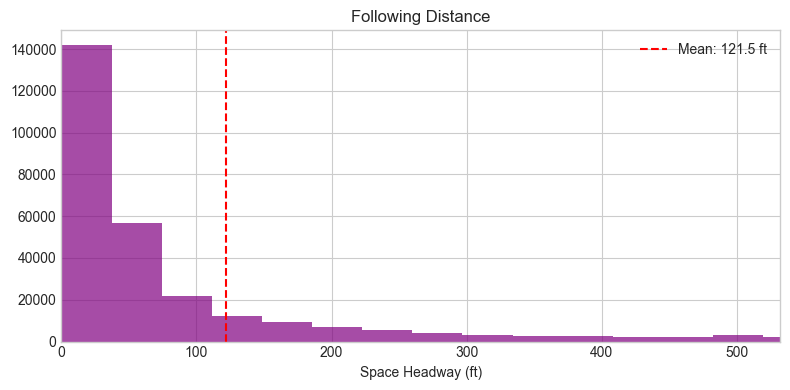

In [12]:
# Space headway distribution
space_hw = df[df['Space_Headway'] > 0]['Space_Headway']

fig, ax = plt.subplots(figsize=(8, 4))
space_hw.hist(bins=50, color='purple', alpha=0.7, ax=ax)
ax.axvline(space_hw.mean(), color='red', linestyle='--', label=f'Mean: {space_hw.mean():.1f} ft')
ax.set_xlabel('Space Headway (ft)')
ax.set_title('Following Distance')
ax.set_xlim(0, space_hw.quantile(0.95))
ax.legend()
plt.tight_layout()
plt.show()

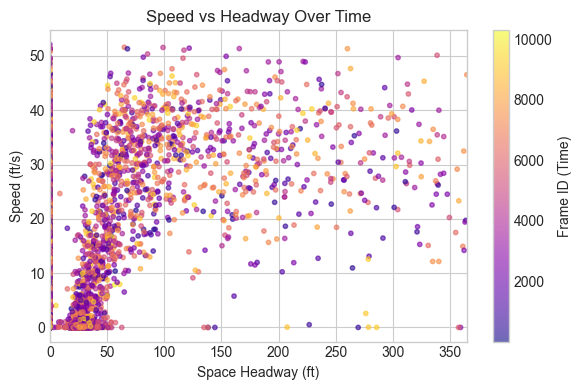

In [22]:
sample = df.sample(5000, random_state=42)

plt.figure(figsize=(6,4))
plt.scatter(
    sample['Space_Headway'],
    sample['v_Vel'],
    c=sample['Frame_ID'],
    cmap='plasma',
    s=10,
    alpha=0.6
)
plt.colorbar(label='Frame ID (Time)')
plt.xlabel('Space Headway (ft)')
plt.ylabel('Speed (ft/s)')
plt.title('Speed vs Headway Over Time')
plt.xlim(0, sample['Space_Headway'].quantile(0.95))
plt.tight_layout()
plt.show()


## 4. Speed Prediction Model (ML)

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


class SpeedPredictor:
    """
    A class to predict vehicle speed using traffic features.
    Uses Random Forest regression model.
    """
    
    def __init__(self, n_estimators=100, random_state=42):
        """Initialize the model with hyperparameters."""
        self.model = RandomForestRegressor(
            n_estimators=n_estimators,
            random_state=random_state,
            n_jobs=-1
        )
        self.feature_cols = None
        self.is_trained = False
    
    def prepare_data(self, df, features, target='v_Vel'):
        """
        Prepare features and target for training.
        Returns X, y arrays with no missing values.
        """
        self.feature_cols = features
        data = df[features + [target]].dropna()
        X = data[features].values
        y = data[target].values
        return X, y
    
    def train(self, X_train, y_train):
        """Train the model on training data."""
        self.model.fit(X_train, y_train)
        self.is_trained = True
        print("Model trained!")
    
    def predict(self, X):
        """Make predictions on new data."""
        if not self.is_trained:
            raise Exception("Model not trained yet!")
        return self.model.predict(X)
    
    def evaluate(self, X_test, y_test):
        """Evaluate model and return metrics."""
        y_pred = self.predict(X_test)
        metrics = {
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'MAE': mean_absolute_error(y_test, y_pred),
            'R2': r2_score(y_test, y_pred)
        }
        return metrics, y_pred
    
    def feature_importance(self):
        """Get feature importance scores."""
        if not self.is_trained:
            raise Exception("Model not trained yet!")
        return dict(zip(self.feature_cols, self.model.feature_importances_))

In [23]:
# Train the model
features = ['Lane_ID', 'Local_X', 'Local_Y', 'v_Acc', 'Space_Headway', 'v_length']
predictor = SpeedPredictor(n_estimators=100)

# Prepare data
X, y = predictor.prepare_data(df, features, target='v_Vel')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")

# Train
predictor.train(X_train, y_train)

Training samples: 400,000
Test samples: 100,000
Model trained!


In [24]:
# Evaluate model
metrics, y_pred = predictor.evaluate(X_test, y_test)

print("MODEL PERFORMANCE")
print("=" * 30)
for name, value in metrics.items():
    print(f"{name}: {value:.3f}")

# Feature importance
print("\nFEATURE IMPORTANCE")
print("-" * 30)
importance = predictor.feature_importance()
for feat, imp in sorted(importance.items(), key=lambda x: -x[1]):
    print(f"{feat}: {imp:.3f}")

MODEL PERFORMANCE
RMSE: 3.878
MAE: 1.846
R2: 0.935

FEATURE IMPORTANCE
------------------------------
Space_Headway: 0.410
Local_Y: 0.217
v_Acc: 0.120
Local_X: 0.111
Lane_ID: 0.091
v_length: 0.051


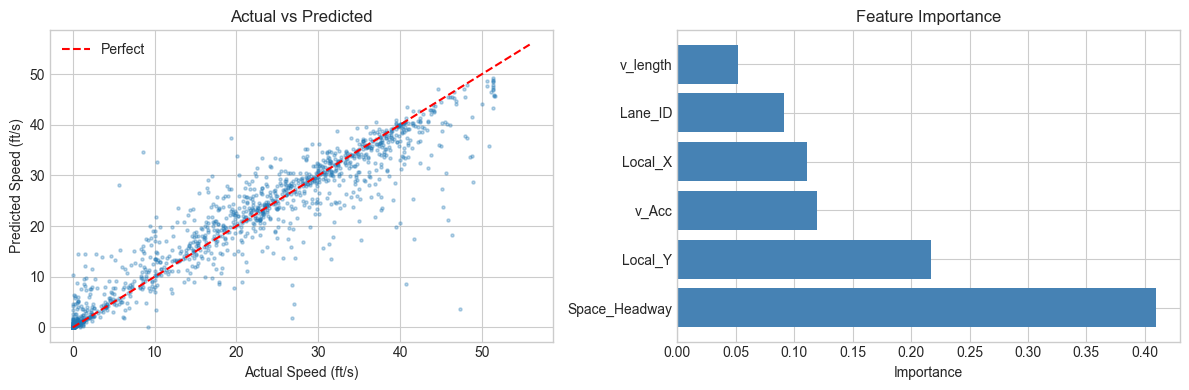

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4)) 
# Scatter plot 
sample_idx = np.random.choice(len(y_test), min(2000, len(y_test)), replace=False) 
axes[0].scatter(y_test[sample_idx], y_pred[sample_idx], alpha=0.3, s=5) 
axes[0].plot([0, y_test.max()], [0, y_test.max()], 'r--', label='Perfect') 
axes[0].set_xlabel('Actual Speed (ft/s)') 
axes[0].set_ylabel('Predicted Speed (ft/s)') 
axes[0].set_title('Actual vs Predicted') 
axes[0].legend() 
# Feature importance bar chart 
imp_sorted = sorted(importance.items(), key=lambda x: -x[1]) 
axes[1].barh([x[0] for x in imp_sorted], [x[1] for x in imp_sorted], color='steelblue') 
axes[1].set_xlabel('Importance') 
axes[1].set_title('Feature Importance') 
plt.tight_layout() 
plt.show()

In [26]:
def test_sample_predict(predictor, sample_dict):
    """
    Test a single sample with prefilled/dynamic values.

    Parameters:
    - predictor: trained SpeedPredictor object
    - sample_dict: dictionary of feature_name: value

    Returns:
    - predicted speed (v_Vel)
    """
    if not predictor.is_trained:
        raise Exception("Model not trained yet!")

    # Make sure all features are included in the sample
    X_sample = np.array([[sample_dict[feat] for feat in predictor.feature_cols]])
    
    # Predict
    pred_speed = predictor.predict(X_sample)[0]
    return pred_speed


# Example usage
sample_input = {
    'Lane_ID': 1,
    'Local_X': -5.0,
    'Local_Y': 0.0,
    'v_Acc': 0.0,
    'Space_Headway': 500.0,
    'v_length': 15.0
}

predicted_speed = test_sample_predict(predictor, sample_input)
print(f"Predicted Speed (ft/s): {predicted_speed:.2f}")


Predicted Speed (ft/s): 17.13
